### Data Sources

##### 1. https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset (Brazil) - .PNG
##### 2. https://www.kaggle.com/luisblanche/covidct (Mixed) -.JPG

### Using Brazil's Data for training & validation while Mixed Data for test

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("bright", 10)
sns.set(rc={'figure.figsize':(12,8)})

from skimage.transform import resize
from skimage import feature
import cv2
from google.colab.patches import cv2_imshow
import PIL
from PIL import Image
from PIL import ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import autograd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

### Function to Measure the Model Performance

In [ ]:
def accuracy_metrics(y, y_pred, y_prob):
    results = confusion_matrix(y, y_pred) 
    print('Confusion Matrix :')
    print(results) 
    print('Accuracy :  ', round(accuracy_score(y, y_pred), 2))
    print('Precision : ', round(precision_score(y, y_pred), 2))
    print('Recall :    ', round(recall_score(y, y_pred), 2))
    print('FI Score :  ', round(f1_score(y, y_pred), 2))
    print('AUC :       ', round(roc_auc_score(y, y_prob), 2))

### Display Sample Images

In [ ]:
#function to enhance images
def enhance_contrast(image, contrast = 1.5):
    image = Image.fromarray(image)
    enh_con = ImageEnhance.Contrast(image)
    image_contrasted = enh_con.enhance(contrast)
    cr_img = np.array(image_contrasted)
    return cr_img

def enhance_brightness(image, brightness = 1.5):
    image = Image.fromarray(image)
    enh_bri = ImageEnhance.Brightness(image)
    image_brigthened = enh_bri.enhance(brightness)
    cr_img = np.array(image_brigthened)
    return cr_img

#### Covid Images

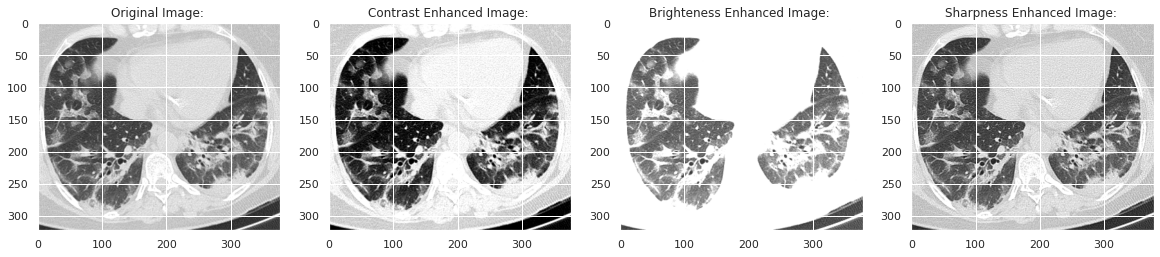

In [ ]:
img = cv2.imread('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/SARS-COV-2 Ct-Scan/Covid/Covid (11).png')

contrast_image = enhance_contrast(img)
bright_image = enhance_brightness(img)
sharp_image = enhance_sharpness(img)

fig, axs = plt.subplots(1, 4, figsize = (20, 20))
axs[0].imshow(img)
axs[0].set_title('Original Image: ')
axs[1].imshow(contrast_image)
axs[1].set_title('Contrast Enhanced Image: ')
axs[2].imshow(bright_image)
axs[2].set_title('Brighteness Enhanced Image: ')
axs[3].imshow(sharp_image)
axs[3].set_title('Sharpness Enhanced Image: ')
plt.show()

#### Non Covid Images

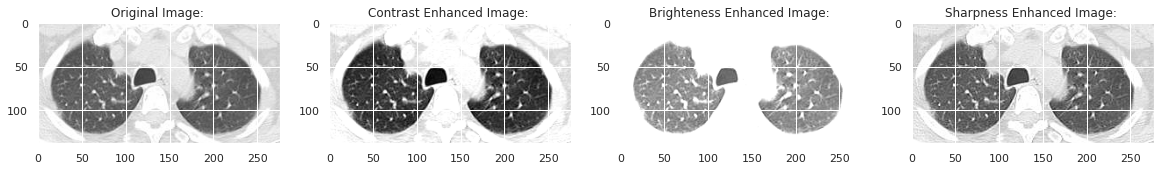

In [ ]:
img = cv2.imread('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/SARS-COV-2 Ct-Scan/Non_Covid/Non-Covid (251).png')

contrast_image = enhance_contrast(img)
bright_image = enhance_brightness(img)
sharp_image = enhance_sharpness(img)

fig, axs = plt.subplots(1, 4, figsize = (20, 20))
axs[0].imshow(img)
axs[0].set_title('Original Image: ')
axs[1].imshow(contrast_image)
axs[1].set_title('Contrast Enhanced Image: ')
axs[2].imshow(bright_image)
axs[2].set_title('Brighteness Enhanced Image: ')
axs[3].imshow(sharp_image)
axs[3].set_title('Sharpness Enhanced Image: ')
plt.show()

### Data Size

In [ ]:
path_1 = "/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/SARS-COV-2 Ct-Scan/"
data_size_1 = len(glob.glob(path_1 + "*/*"))

path_2 = "/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/CT-Covid/"
data_size_2 = len(glob.glob(path_2 + "*/*"))

combined_path = "/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/"
data_size_combined = len(glob.glob(combined_path + "*/*"))

print(data_size_1, data_size_2, data_size_combined)

2481 487 2968


### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224), enhance = False, enhance_fun = enhance_contrast):
        #self.imgs_path = "/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/SARS-COV-2 Ct-Scan/"
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
        self.enhance = enhance
        self.enhance_func = enhance_fun
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.enhance:
           img = self.enhance_func(img)  
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

There are 2 different data sources. 1st source has CT Scan images in .PNG format from Brazil whereas, 2nd data source has images from all over the world in .JPG format. 1st Data will be divided into train & validation while 2nd data will be used as test data.

We will check if any of image enhancement methods are able to boost the performance or not!

### 1. Baseline CNN on Different Data Sources for Training & Testing without Image Enhancement

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_1))
split = int(np.floor(validation_split * data_size_1))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices = indices[2*split:], indices[:split]
#train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

dataset_1 = CustomDataset(path = path_1, enhance = False)
train_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = val_sampler, num_workers = 2)

dataset_2 = CustomDataset(path = path_2, enhance = False)
test_loader = torch.utils.data.DataLoader(dataset_2, batch_size = batch_size, num_workers = 2)
#test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#cnn model class
def call_bn(bn, x):
    return bn(x)

class CNN(nn.Module):
    def __init__(self, in_channels = 3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(64, 96, kernel_size = 3)
        self.conv4 = nn.Conv2d(96, 96, kernel_size = 3)
        self.conv5 = nn.Conv2d(96, 128, kernel_size = 3)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3)
        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(96)
        self.bn4 = nn.BatchNorm2d(96)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(64)

    def forward(self, x, verbose = False):
        x = self.conv1(x)
        x = call_bn(self.bn1, x)
        x = F.relu(x)
        x = self.conv2(x)
        x = call_bn(self.bn2, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = call_bn(self.bn3, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = call_bn(self.bn4, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = call_bn(self.bn5, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv6(x)
        x = call_bn(self.bn6, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
      
        x = x.view(-1, 128 * 5 * 5)
        
        x = self.fc1(x)
        x = call_bn(self.bn7, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = call_bn(self.bn8, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [ ]:
#initialise model
model = CNN()

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1,

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-5)

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 50

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_raw.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.57409 | Train Accuracy: 72.654 % | Validation Loss: 0.69820 | Validation Accuracy: 51.075 %
Epoch 2: | Train Loss: 0.47044 | Train Accuracy: 84.283 % | Validation Loss: 0.47722 | Validation Accuracy: 86.559 %
Epoch 3: | Train Loss: 0.45494 | Train Accuracy: 86.068 % | Validation Loss: 0.59941 | Validation Accuracy: 68.817 %
Epoch 4: | Train Loss: 0.44746 | Train Accuracy: 86.356 % | Validation Loss: 0.46467 | Validation Accuracy: 85.215 %
Epoch 5: | Train Loss: 0.43334 | Train Accuracy: 88.025 % | Validation Loss: 0.63847 | Validation Accuracy: 64.247 %
Epoch 6: | Train Loss: 0.42716 | Train Accuracy: 88.889 % | Validation Loss: 0.46254 | Validation Accuracy: 84.677 %
Epoch 7: | Train Loss: 0.42605 | Train Accuracy: 88.428 % | Validation Loss: 0.46635 | Validation Accuracy: 83.871 %
Epoch 8: | Train Loss: 0.42852 | Train Accuracy: 87.853 % | Validation Loss: 0.46161 | Validation Accuracy: 84.946 %
Epoch 9: | Train Loss: 0.42414 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_raw.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Train Data (Brazil): %d %%' % (100 * correct / total))


correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Validation Data (Brazil): %d %%' % (100 * correct / total))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Test Data (China): %d %%' % (100 * correct / total))

Accuracy on Train Data (Brazil): 94 %
Accuracy on Validation Data (Brazil): 91 %
Accuracy on Test Data (China): 43 %


### 2. Baseline CNN on Different Data Sources for Training & Testing with Contrast Enhancement

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_1))
split = int(np.floor(validation_split * data_size_1))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices = indices[2*split:], indices[:split]
#train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

dataset_1 = CustomDataset(path = path_1, enhance = True, enhance_fun = enhance_contrast)
train_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = val_sampler, num_workers = 2)

dataset_2 = CustomDataset(path = path_2, enhance = True, enhance_fun = enhance_contrast)
test_loader = torch.utils.data.DataLoader(dataset_2, batch_size = batch_size, num_workers = 2)
#test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

In [ ]:
#cnn model class
def call_bn(bn, x):
    return bn(x)

class CNN(nn.Module):
    def __init__(self, in_channels = 3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(64, 96, kernel_size = 3)
        self.conv4 = nn.Conv2d(96, 96, kernel_size = 3)
        self.conv5 = nn.Conv2d(96, 128, kernel_size = 3)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3)
        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(96)
        self.bn4 = nn.BatchNorm2d(96)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(64)

    def forward(self, x, verbose = False):
        x = self.conv1(x)
        x = call_bn(self.bn1, x)
        x = F.relu(x)
        x = self.conv2(x)
        x = call_bn(self.bn2, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = call_bn(self.bn3, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = call_bn(self.bn4, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = call_bn(self.bn5, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv6(x)
        x = call_bn(self.bn6, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
      
        x = x.view(-1, 128 * 5 * 5)
        
        x = self.fc1(x)
        x = call_bn(self.bn7, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = call_bn(self.bn8, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [ ]:
#initialise model
model = CNN()

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-5)

In [ ]:
#training
start_epoch = 0
epochs = 50

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_contrast.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.57621 | Train Accuracy: 72.366 % | Validation Loss: 0.71921 | Validation Accuracy: 56.720 %
Epoch 2: | Train Loss: 0.46041 | Train Accuracy: 86.298 % | Validation Loss: 0.75271 | Validation Accuracy: 52.151 %
Epoch 3: | Train Loss: 0.43492 | Train Accuracy: 87.853 % | Validation Loss: 0.62745 | Validation Accuracy: 68.280 %
Epoch 4: | Train Loss: 0.44500 | Train Accuracy: 86.356 % | Validation Loss: 0.77603 | Validation Accuracy: 52.688 %
Epoch 5: | Train Loss: 0.42618 | Train Accuracy: 88.428 % | Validation Loss: 0.61828 | Validation Accuracy: 68.280 %
Epoch 6: | Train Loss: 0.42537 | Train Accuracy: 89.119 % | Validation Loss: 0.70959 | Validation Accuracy: 58.871 %
Epoch 7: | Train Loss: 0.43119 | Train Accuracy: 87.737 % | Validation Loss: 0.71555 | Validation Accuracy: 58.871 %
Epoch 8: | Train Loss: 0.40287 | Train Accuracy: 91.077 % | Validation Loss: 0.64425 | Validation Accuracy: 65.591 %
Epoch 9: | Train Loss: 0.41358 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_contrast.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Train Data (Brazil): %d %%' % (100 * correct / total))


correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Validation Data (Brazil): %d %%' % (100 * correct / total))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Test Data (China): %d %%' % (100 * correct / total))

Accuracy on Train Data (Brazil): 95 %
Accuracy on Validation Data (Brazil): 92 %
Accuracy on Test Data (China): 47 %


Compared to model trained on raw ct for Brazil data, its performance for China increased by significant margin.

### 3. Baseline CNN on Different Data Sources for Training & Testing with Brightness Enhancement

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_1))
split = int(np.floor(validation_split * data_size_1))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices = indices[2*split:], indices[:split]
#train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

dataset_1 = CustomDataset(path = path_1, enhance = True, enhance_fun = enhance_brightness)
train_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_1, batch_size = batch_size, sampler = val_sampler, num_workers = 2)

dataset_2 = CustomDataset(path = path_2, enhance = True, enhance_fun = enhance_brightness)
test_loader = torch.utils.data.DataLoader(dataset_2, batch_size = batch_size, num_workers = 2)
#test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

In [ ]:
#cnn model class
def call_bn(bn, x):
    return bn(x)

class CNN(nn.Module):
    def __init__(self, in_channels = 3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(64, 96, kernel_size = 3)
        self.conv4 = nn.Conv2d(96, 96, kernel_size = 3)
        self.conv5 = nn.Conv2d(96, 128, kernel_size = 3)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3)
        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(96)
        self.bn4 = nn.BatchNorm2d(96)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(64)

    def forward(self, x, verbose = False):
        x = self.conv1(x)
        x = call_bn(self.bn1, x)
        x = F.relu(x)
        x = self.conv2(x)
        x = call_bn(self.bn2, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = call_bn(self.bn3, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = call_bn(self.bn4, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = call_bn(self.bn5, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv6(x)
        x = call_bn(self.bn6, x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
      
        x = x.view(-1, 128 * 5 * 5)
        
        x = self.fc1(x)
        x = call_bn(self.bn7, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = call_bn(self.bn8, x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [ ]:
#initialise model
model = CNN()

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-5)

In [ ]:
#training
start_epoch = 0
epochs = 50

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_brightness.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.57146 | Train Accuracy: 74.381 % | Validation Loss: 0.69055 | Validation Accuracy: 59.946 %
Epoch 2: | Train Loss: 0.48341 | Train Accuracy: 83.189 % | Validation Loss: 0.70845 | Validation Accuracy: 58.871 %
Epoch 3: | Train Loss: 0.46019 | Train Accuracy: 85.665 % | Validation Loss: 0.67857 | Validation Accuracy: 62.634 %
Epoch 4: | Train Loss: 0.45712 | Train Accuracy: 85.492 % | Validation Loss: 0.66840 | Validation Accuracy: 63.710 %
Epoch 5: | Train Loss: 0.43535 | Train Accuracy: 87.968 % | Validation Loss: 0.64566 | Validation Accuracy: 63.441 %
Epoch 6: | Train Loss: 0.44451 | Train Accuracy: 86.183 % | Validation Loss: 0.53330 | Validation Accuracy: 77.151 %
Epoch 7: | Train Loss: 0.42979 | Train Accuracy: 88.025 % | Validation Loss: 0.59112 | Validation Accuracy: 69.624 %
Epoch 8: | Train Loss: 0.43027 | Train Accuracy: 87.853 % | Validation Loss: 0.71088 | Validation Accuracy: 59.677 %
Epoch 9: | Train Loss: 0.41786 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/cnn_ct_brightness.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Train Data (Brazil): %d %%' % (100 * correct / total))


correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Validation Data (Brazil): %d %%' % (100 * correct / total))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)      #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on Test Data (China): %d %%' % (100 * correct / total))

Accuracy on Train Data (Brazil): 94 %
Accuracy on Validation Data (Brazil): 91 %
Accuracy on Test Data (China): 48 %


Compared to model trained on raw ct, its performance for Mixed Data increased by significant margin.